In [1]:
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import date
from os.path import join, isfile
from os import listdir
import time
from sklearn.metrics import f1_score
import tensorflow as tf 
from statistics import mode
from itertools import combinations
import pointnet_model

In [2]:
def read_rep(syn, control, syn_csv, ID_csv, data_dir):
    
    # open directories
    syn_dir = data_dir+"\\{}-patients".format(syn)
    ID_dir = data_dir+ "\\{}-selected-{}-controls".format(syn, control)

    # get list of filenames
    files_syn = [f for f in listdir(syn_dir) if (isfile(join(syn_dir, f))) and ".jpg" in f]
    files_ID = [f for f in listdir(ID_dir) if (isfile(join(ID_dir, f))) and ".jpg" in f]
    
    data_syn, data_ID, labels_syn, labels_ID = [], [], [], []
    
    with open (syn_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for index, row in enumerate(reader):
            if row[0] in files_syn: 
                rep = list(map(float, row[1:]))
                data_syn.append(rep)
                labels_syn.append(1)

    with open (ID_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for index, row in enumerate(reader):
            if row[0] in files_ID:
                rep = list(map(float, row[1:]))
                data_ID.append(rep)
                labels_ID.append(0)
            
    return np.array(data_syn), np.array(data_ID), np.array(labels_syn), np.array(labels_ID)

In [3]:
def read_rep_landmarks(syn, control, syn_csv, ID_csv, data_dir):
    
    # open directories
    syn_dir = data_dir+"\\{}-patients".format(syn)
    ID_dir = data_dir+ "\\{}-selected-{}-controls".format(syn, control)

    # get list of filenames
    files_syn = [f for f in listdir(syn_dir) if (isfile(join(syn_dir, f))) and ".jpg" in f]
    files_ID = [f for f in listdir(ID_dir) if (isfile(join(ID_dir, f))) and ".jpg" in f]

    data_syn, data_ID, labels_syn, labels_ID = [], [], [], []

    with open (syn_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for index, row in enumerate(reader):
            if row[0] in files_syn:
                rep = []
                i = 1
                while i < len(row[1:]):
                    rep.append([float(row[i]), float(row[i+1]), float(row[i+2])])
                    i+=3                       
                data_syn.append(rep)
                labels_syn.append(1)

    with open (ID_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for index, row in enumerate(reader):
            if row[0] in files_ID:
                rep = []
                i = 1
                while i < len(row[1:]):
                    rep.append([float(row[i]), float(row[i+1]), float(row[i+2])])
                    i+=3                       
                data_ID.append(rep)
                labels_ID.append(0)

    return np.array(data_syn), np.array(data_ID), np.array(labels_syn), np.array(labels_ID)

In [4]:
def read_rep_oc(syn, control, syn_csv, ID_csv, data_dir):    
    # open directories
    syn_dir = data_dir+"\\{}-patients".format(syn)
    ID_dir = data_dir+ "\\{}-selected-{}-controls".format(syn, control)

    # get list of filenames
    files_syn = [f for f in listdir(syn_dir) if (isfile(join(syn_dir, f))) and ".jpg" in f]
    files_ID = [f for f in listdir(ID_dir) if (isfile(join(ID_dir, f))) and ".jpg" in f]
    
    data_syn, data_ID = [], []

    with open (syn_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for row in reader:
            if row[0] in files_syn:
                data_syn.append(row)
                    
    with open (ID_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for row in reader:
            if row[0] in files_ID:
                data_ID.append(row)
    
    return np.array(data_syn), np.array(data_ID)

In [5]:
def combine_openface_cfps(syn, control, data_dir):             
                
    method = "openface"
    syn_csv = data_dir+"\\representations\\{}-patients-{}.csv".format(syn, method)
    ID_csv  = data_dir+"\\representations\\{}-controls-{}.csv".format(control, method)
    data_syn_of, data_ID_of = read_rep_oc(syn, control, syn_csv, ID_csv, data_dir)
                
    method = "cfps"
    syn_csv = data_dir+"\\representations\\{}-patients-{}.csv".format(syn, method)
    ID_csv  = data_dir+"\\representations\\{}-controls-{}.csv".format(control, method)
    data_syn_cfps, data_ID_cfps = read_rep_oc(syn, control, syn_csv, ID_csv, data_dir)
       
    data_syn, data_ID = [], []
    labels = []
    indices_syn, indices_ID = [], []

    for openface_i in data_syn_of:
        img_name = openface_i[0]
        if img_name in data_syn_cfps[:,0]:
            index = data_syn_cfps[:,0].tolist().index(img_name)
            
            data_syn.append(openface_i[1:].tolist() + data_syn_cfps[index,1:].tolist())
    
    for openface_i in data_ID_of:
        img_name = openface_i[0]
        if img_name in data_ID_cfps[:,0]:
            index = data_ID_cfps[:,0].tolist().index(img_name)
            
            data_ID.append(openface_i[1:].tolist() + data_ID_cfps[index,1:].tolist())
    
    if len(data_ID) > len(data_syn):
        data_ID = data_ID[:len(data_syn)]
    else:
        data_syn = data_syn[:len(data_ID)]

    data = data_syn + data_ID
    labels = np.ones(len(data_syn)).tolist() + np.zeros(len(data_ID)).tolist()

    return np.array(data), np.array(labels)

In [6]:
def normalize(data_1, data_2, data_3):
    data_1 = Normalizer().fit_transform(data_1)
    data_2 = Normalizer().fit_transform(data_2)
    data_3 = Normalizer().fit_transform(data_3)
    return data_1, data_2, data_3

In [7]:
def load_data(GENERAL_DIR, syn, control, data_dir): 

    method = "deepface"   
    syn_csv = data_dir+"\\representations\\{}-patients-{}.csv".format(syn, method)
    ID_csv  = data_dir+"\\representations\\{}-controls-{}.csv".format(control, method)
    data_syn_df, data_ID_df, labels_syn_df, labels_ID_df = read_rep(syn, control, syn_csv, ID_csv, data_dir)
    
    method = "facereader-landmarks"
    syn_csv = GENERAL_DIR+ "\\features_facereader_landmarks_patient_groups.csv"
    data_syn_fr, data_ID_fr, _, _ = read_rep_landmarks(syn, control, syn_csv, syn_csv, data_dir)    
    
    method = "facereader-landmarks-distances"
    syn_csv = GENERAL_DIR+ "\\features_facereader_landmarks_distances_patient_groups_left_right.csv"
    data_syn_dis, data_ID_dis, _,  _ = read_rep(syn, control, syn_csv, syn_csv, data_dir)  
    
    # openface + cfps
    data_oc, labels_oc = combine_openface_cfps(syn, control, data_dir)
   
    indices_to_keep = []
    for index, rep in enumerate(data_syn_dis):
        if not all(v == 0 for v in data_syn_dis[index]) and not all(v == 0 for v in data_ID_dis[index]):
            indices_to_keep.append(index)
                
    # all deepface data
    data_df = data_syn_df.tolist() + data_ID_df.tolist()
    labels_df = labels_syn_df.tolist() + labels_ID_df.tolist()
    
    # only deepface (that also has a facereader rep)
    data_syn_df_drop = data_syn_df[indices_to_keep]
    data_ID_df_drop = data_ID_df[indices_to_keep]
    data_df_drop = data_syn_df_drop.tolist() + data_ID_df_drop.tolist()
    
    # facereader landmarks 
    data_syn_fr = data_syn_fr[indices_to_keep]
    data_ID_fr = data_ID_fr[indices_to_keep]
    data_fr = data_syn_fr.tolist() + data_ID_fr.tolist()
    
    # only distance with facereader rep
    data_syn_dis = data_syn_dis[indices_to_keep]
    data_ID_dis = data_ID_dis[indices_to_keep]
    data_dis = data_syn_dis.tolist() + data_ID_dis.tolist()
    
    # labels with facereader rep
    labels_syn_df = labels_syn_df[indices_to_keep]
    labels_ID_df = labels_ID_df[indices_to_keep]
    labels = labels_syn_df.tolist() + labels_ID_df.tolist() 

    return np.array(data_df), np.array(data_df_drop), np.array(data_fr), np.array(data_dis), np.array(data_oc).astype(np.float32), np.array(labels_df), np.array(labels), np.array(labels_oc)

In [8]:
def knn_classifier(data, labels):
    y_true, y_probs, y_preds = [], [], [] 
    loo = LeaveOneOut()

    # leave one out split and make prediction
    for train_index, test_index in loo.split(data):
        y_true.append(labels[test_index])
        
        X_train, X_test = np.array(data[train_index]), data[test_index]
        y_train, _ = np.array(labels[train_index]), labels[test_index]
        
        model = KNeighborsClassifier(n_neighbors=3, weights='distance')
        model.fit(X_train, y_train)
        
        y_probs.append(model.predict_proba(X_test)[:,1])
        y_preds.append(model.predict(X_test))
        
        del model

    # based on all predictions make aroc curve and confusion matrix
    aroc = roc_auc_score(y_true, y_probs)
    tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()
    spec = tn / (tn+fp)  
    sens = tp / (tp+fn)
    f1 = f1_score(y_true, y_preds)
                
    return aroc, spec, sens, f1, y_true, y_probs, y_preds

In [9]:
def pointnet_classifier(data, labels):
    y_true, y_probs, y_preds = [], [], [] 
    loo = LeaveOneOut()
    
    for train_index, test_index in loo.split(data):
        y_true.append(labels[test_index])

        X_train, X_test = np.array(data[train_index]), data[test_index]
        y_train, _ = np.array(labels[train_index]), labels[test_index]

        model = pointnet_model.generate_model()
        model.fit(x=X_train, y=y_train, batch_size=BATCH_SIZE, epochs=4, shuffle=True)

        y_pred_array = model.predict(X_test)
        y_pred = tf.math.argmax(y_pred_array, -1).numpy()

        y_probs.append(y_pred_array[0][1])
        y_preds.append(y_pred) 
        
        del model
        
    aroc = roc_auc_score(y_true, y_probs)
    tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()
    spec = tn / (tn+fp)  
    sens = tp / (tp+fn)
    f1 = f1_score(y_true, y_preds)
    
    return aroc, spec, sens, f1, y_true, y_probs, y_preds

In [10]:
def randomforest_classifier(data, labels):
    y_true, y_probs, y_preds = [], [], [] 
    loo = LeaveOneOut()
    
    for train_index, test_index in loo.split(data):
        y_true.append(labels[test_index])

        X_train, X_test = np.array(data[train_index]), data[test_index]
        y_train, _ = np.array(labels[train_index]), labels[test_index]

        model = RandomForestClassifier(n_estimators=10)
        model.fit(X_train, y_train)

        y_probs.append(model.predict_proba(X_test.reshape(1, -1))[:,1])
        y_preds.append(model.predict(X_test.reshape(1, -1)))
        
        del model

    aroc = roc_auc_score(y_true, y_probs)
    tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()
    spec = tn / (tn+fp)  
    sens = tp / (tp+fn)
    f1 = f1_score(y_true, y_preds)
    
    return aroc, spec, sens, f1, y_true, y_probs, y_preds

In [11]:
syn_list = ['ADNP', 'ANKRD11', 'CDK13', 'DEAF1', 'DYRK1A', 'EHMT1', 'FBXO11', 'KDVS', 'SON', 'WAC', 'YY1']
syn_combs = list(combinations(syn_list, 2))
print(len(syn_combs))

55


In [12]:
results_df_all = np.zeros((len(syn_list), len(syn_list)))
results_df = np.zeros((len(syn_list), len(syn_list)))
results_pn = np.zeros((len(syn_list), len(syn_list)))
results_rf = np.zeros((len(syn_list), len(syn_list)))
results_en = np.zeros((len(syn_list), len(syn_list)))
results_oc = np.zeros((len(syn_list), len(syn_list)))

In [13]:
# filter version
GENERAL_DIR = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien" 
BATCH_SIZE = 8

## open file 
results_file = open("results/ensemble_results_3_models_run_1.txt", "w")
start = time.time()
# read in all data (per syndrome) which has a facereader and deepface representation
for (syn, control) in syn_combs:
    
    i = syn_list.index(syn)
    j = syn_list.index(control)
    
    data_dir = GENERAL_DIR + "\\syn_vs_syn\\{}-{}".format(syn, control) 
    print("Syndrome that will be classified: {} - {} \n\n".format(syn, control))
    results_file.write("Syndrome: {} - {} \n".format(syn, control))
    
    data_df_all, data_df, data_fr, data_dis, data_oc, labels_df_all, labels, labels_oc = load_data(GENERAL_DIR, syn, control, data_dir)    
      
    # all predictions 
    print("deepface", data_df.shape)   
    print("pointnet", data_fr.shape)  
    print("distances", data_dis.shape)
    print("openface+cfps", data_oc.shape)
    
    data_df_all, data_df, data_dis = normalize(data_df_all, data_df, data_dis)   
    
    # DEEPFACE - KNN - all
    aroc_df_all, spec_df_all, sens_df_all, f1_df_all, _, _, _ = knn_classifier(data_df_all, labels_df_all)
    results_file.write("Deepface with {} patients and {} controls\n".format(labels_df_all.tolist().count(1), labels_df_all.tolist().count(0)))
    results_file.write("AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}, F1: {:.4f}\n\n".format(aroc_df_all, spec_df_all, sens_df_all, f1_df_all))
    
    results_df_all[i][j] = aroc_df_all
    
    # DEEPFACE - KNN 
    aroc_df, spec_df, sens_df, f1_df, y_true_df, y_probs_df, y_preds_df = knn_classifier(data_df, labels)
    results_file.write("Deepface with {} patients and {} controls\n".format(labels.tolist().count(1), labels.tolist().count(0)))
    results_file.write("AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}, F1: {:.4f}\n\n".format(aroc_df, spec_df, sens_df, f1_df))
           
    results_df[i][j] = aroc_df_all

    # POINTNET 
    aroc_pn, spec_pn, sens_pn, f1_pn, y_true_pn, y_probs_pn, y_preds_pn = pointnet_classifier(data_fr, labels)
    results_file.write("Pointnet with {} patients and {} controls\n".format(labels.tolist().count(1), labels.tolist().count(0)))
    results_file.write("AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}, F1: {:.4f}\n\n".format(aroc_pn, spec_pn, sens_pn, f1_pn))
                   
    results_pn[i][j] = aroc_df

    # RANDOM FOREST 
    aroc_rf, spec_rf, sens_rf, f1_rf, y_true_rf, y_probs_rf, y_preds_rf = randomforest_classifier(data_dis, labels)
    results_file.write("Random Forest with {} patients and {} controls\n".format(labels.tolist().count(1), labels.tolist().count(0)))
    results_file.write("AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}, F1: {:.4f}\n\n".format(aroc_rf, spec_rf, sens_rf, f1_rf))
    
    results_rf[i][j] = aroc_rf
    
    # OPENFACE-CFPS
    if len(labels_oc) > 3:
        aroc_oc, spec_oc, sens_oc, f1_oc, _, _, _ = knn_classifier(data_oc, labels_oc)
        results_file.write("Openface-CFPS with {} patients and {} controls\n".format(labels_oc.tolist().count(1), labels_oc.tolist().count(0)))
        results_file.write("AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}, F1: {:.4f}\n\n".format(aroc_oc, spec_oc, sens_oc, f1_oc))

        results_oc[i][j] = aroc_oc   
    else:
        results_file.write("Openface-CFPS with {} patients and {} controls\n".format(labels_oc.tolist().count(1), labels_oc.tolist().count(0)))
        results_file.write("Not enough data\n\n")


    #ensemble mean 
    ensemble_probs, ensemble_preds = [], []
    for index, _ in enumerate(y_true_df):
        mean_prob = np.mean([y_probs_df[index], y_probs_pn[index], y_probs_rf[index]])
        ensemble_probs.append(mean_prob)
        
        mode_pred = mode([y_preds_df[index][0], y_preds_pn[index][0], y_preds_rf[index][0]])
        ensemble_preds.append(mode_pred)
        
    aroc_ensemble = roc_auc_score(y_true_df, ensemble_probs)
    tn_en, fp_en, fn_en, tp_en = confusion_matrix(y_true_df, ensemble_preds).ravel()
    spec_ensemble = tn_en / (tn_en+fp_en)  
    sens_ensemble = tp_en / (tp_en+fn_en)
    f1_ensemble = f1_score(y_true_df, ensemble_preds)
    
    results_file.write("Ensemble classifier mean and mode \n".format(labels.tolist().count(1), labels.tolist().count(0)))
    results_file.write("AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}, F1: {:.4f}\n\n".format(aroc_ensemble, spec_ensemble, sens_ensemble, f1_ensemble))
    
    results_en[i][j] = aroc_ensemble
    
end = time.time()
results_file.write("This script took {:.4f} hours".format((end-start)/3600))        
results_file.close()

Syndrome that will be classified: ADNP - ANKRD11 


deepface (12, 4096)
pointnet (12, 510, 3)
distances (12, 72630)
openface+cfps (26, 468)
Epoch 1/4
2/2 [==============================] - 0s 53ms/step - loss: 1.0888 - sparse_categorical_accuracy: 0.6364
Epoch 2/4
2/2 [==============================] - 0s 45ms/step - loss: 1.4125 - sparse_categorical_accuracy: 0.4545
Epoch 3/4
2/2 [==============================] - 0s 46ms/step - loss: 1.0898 - sparse_categorical_accuracy: 0.7273
Epoch 4/4
2/2 [==============================] - 0s 47ms/step - loss: 1.1546 - sparse_categorical_accuracy: 0.7273
Epoch 1/4
2/2 [==============================] - 0s 51ms/step - loss: 1.3607 - sparse_categorical_accuracy: 0.4545
Epoch 2/4
2/2 [==============================] - 0s 46ms/step - loss: 1.4428 - sparse_categorical_accuracy: 0.3636
Epoch 3/4
2/2 [==============================] - 0s 47ms/step - loss: 1.0585 - sparse_categorical_accuracy: 0.6364
Epoch 4/4
2/2 [==============================] - 0s 46m

2/2 [==============================] - 0s 87ms/step - loss: 1.3469 - sparse_categorical_accuracy: 0.6154
Epoch 2/4
2/2 [==============================] - 0s 80ms/step - loss: 1.3965 - sparse_categorical_accuracy: 0.5385
Epoch 3/4
2/2 [==============================] - 0s 80ms/step - loss: 1.1413 - sparse_categorical_accuracy: 0.6923
Epoch 4/4
2/2 [==============================] - 0s 81ms/step - loss: 1.7771 - sparse_categorical_accuracy: 0.3846
Epoch 1/4
2/2 [==============================] - 0s 88ms/step - loss: 1.3378 - sparse_categorical_accuracy: 0.5385
Epoch 2/4
2/2 [==============================] - 0s 79ms/step - loss: 1.2206 - sparse_categorical_accuracy: 0.6154
Epoch 3/4
2/2 [==============================] - 0s 80ms/step - loss: 1.1907 - sparse_categorical_accuracy: 0.6923
Epoch 4/4
2/2 [==============================] - 0s 80ms/step - loss: 1.6523 - sparse_categorical_accuracy: 0.6923
Epoch 1/4
2/2 [==============================] - 0s 87ms/step - loss: 1.0513 - sparse_cate

2/2 [==============================] - 0s 79ms/step - loss: 1.1768 - sparse_categorical_accuracy: 0.6154
Epoch 4/4
2/2 [==============================] - 0s 88ms/step - loss: 0.8929 - sparse_categorical_accuracy: 0.8462
Epoch 1/4
2/2 [==============================] - 0s 86ms/step - loss: 1.3189 - sparse_categorical_accuracy: 0.6923
Epoch 2/4
2/2 [==============================] - 0s 81ms/step - loss: 1.0614 - sparse_categorical_accuracy: 0.7692
Epoch 3/4
2/2 [==============================] - 0s 87ms/step - loss: 1.2098 - sparse_categorical_accuracy: 0.4615
Epoch 4/4
2/2 [==============================] - 0s 80ms/step - loss: 0.9399 - sparse_categorical_accuracy: 0.9231
Epoch 1/4
2/2 [==============================] - 0s 83ms/step - loss: 1.8291 - sparse_categorical_accuracy: 0.4615
Epoch 2/4
2/2 [==============================] - 0s 84ms/step - loss: 1.1918 - sparse_categorical_accuracy: 0.5385
Epoch 3/4
2/2 [==============================] - 0s 80ms/step - loss: 0.9566 - sparse_cate

2/2 [==============================] - 0s 18ms/step - loss: 1.3225 - sparse_categorical_accuracy: 0.4444
Epoch 4/4
2/2 [==============================] - 0s 5ms/step - loss: 1.2938 - sparse_categorical_accuracy: 0.6667
Epoch 1/4
2/2 [==============================] - 0s 10ms/step - loss: 2.1858 - sparse_categorical_accuracy: 0.3333
Epoch 2/4
2/2 [==============================] - 0s 4ms/step - loss: 1.5903 - sparse_categorical_accuracy: 0.5556
Epoch 3/4
2/2 [==============================] - 0s 9ms/step - loss: 1.4051 - sparse_categorical_accuracy: 0.4444
Epoch 4/4
2/2 [==============================] - 0s 5ms/step - loss: 1.3928 - sparse_categorical_accuracy: 0.7778
Epoch 1/4
2/2 [==============================] - 0s 14ms/step - loss: 1.0132 - sparse_categorical_accuracy: 0.6667
Epoch 2/4
2/2 [==============================] - 0s 7ms/step - loss: 0.9232 - sparse_categorical_accuracy: 0.8889
Epoch 3/4
2/2 [==============================] - 0s 3ms/step - loss: 1.0852 - sparse_categorica

2/2 [==============================] - 0s 20ms/step - loss: 1.5663 - sparse_categorical_accuracy: 0.4444
Epoch 2/4
2/2 [==============================] - 0s 10ms/step - loss: 1.3549 - sparse_categorical_accuracy: 0.5556
Epoch 3/4
2/2 [==============================] - 0s 9ms/step - loss: 0.9668 - sparse_categorical_accuracy: 0.8889
Epoch 4/4
2/2 [==============================] - 0s 7ms/step - loss: 0.8562 - sparse_categorical_accuracy: 1.0000
Syndrome that will be classified: ADNP - KDVS 


deepface (24, 4096)
pointnet (24, 510, 3)
distances (24, 72630)
openface+cfps (62, 468)
Epoch 1/4
3/3 [==============================] - 1s 214ms/step - loss: 1.5413 - sparse_categorical_accuracy: 0.5217
Epoch 2/4
3/3 [==============================] - 1s 203ms/step - loss: 1.1861 - sparse_categorical_accuracy: 0.7826
Epoch 3/4
3/3 [==============================] - 1s 207ms/step - loss: 1.0308 - sparse_categorical_accuracy: 0.8696
Epoch 4/4
3/3 [==============================] - 1s 203ms/step - lo

3/3 [==============================] - 1s 203ms/step - loss: 1.0400 - sparse_categorical_accuracy: 0.8261
Epoch 3/4
3/3 [==============================] - 1s 207ms/step - loss: 1.0344 - sparse_categorical_accuracy: 0.9565
Epoch 4/4
3/3 [==============================] - 1s 203ms/step - loss: 1.0970 - sparse_categorical_accuracy: 0.9130
Epoch 1/4
3/3 [==============================] - 1s 209ms/step - loss: 1.3759 - sparse_categorical_accuracy: 0.4348
Epoch 2/4
3/3 [==============================] - 1s 208ms/step - loss: 0.9519 - sparse_categorical_accuracy: 0.8261
Epoch 3/4
3/3 [==============================] - 1s 208ms/step - loss: 0.9402 - sparse_categorical_accuracy: 0.9130
Epoch 4/4
3/3 [==============================] - 1s 203ms/step - loss: 0.8581 - sparse_categorical_accuracy: 0.9565
Epoch 1/4
3/3 [==============================] - 1s 209ms/step - loss: 1.2460 - sparse_categorical_accuracy: 0.6522
Epoch 2/4
3/3 [==============================] - 1s 203ms/step - loss: 0.8921 - sp

1/1 [==============================] - 0s 0s/step - loss: 0.9331 - sparse_categorical_accuracy: 0.5714
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 1.3954 - sparse_categorical_accuracy: 0.7143
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 1.9073 - sparse_categorical_accuracy: 0.5714
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 1.3083 - sparse_categorical_accuracy: 0.7143
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 1.3119 - sparse_categorical_accuracy: 0.7143
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 1.0605 - sparse_categorical_accuracy: 0.8571
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 1.3533 - sparse_categorical_accuracy: 0.4286
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 0.9708 - sparse_categorical_accuracy: 0.7143
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 0.9461 - sparse_categorical_accuracy: 

2/2 [==============================] - 0s 6ms/step - loss: 1.0548 - sparse_categorical_accuracy: 0.8889
Epoch 1/4
2/2 [==============================] - 0s 11ms/step - loss: 1.5723 - sparse_categorical_accuracy: 0.5556
Epoch 2/4
2/2 [==============================] - 0s 8ms/step - loss: 1.2053 - sparse_categorical_accuracy: 0.7778
Epoch 3/4
2/2 [==============================] - 0s 9ms/step - loss: 1.9089 - sparse_categorical_accuracy: 0.4444
Epoch 4/4
2/2 [==============================] - 0s 11ms/step - loss: 1.2998 - sparse_categorical_accuracy: 0.6667
Epoch 1/4
2/2 [==============================] - 0s 24ms/step - loss: 1.4152 - sparse_categorical_accuracy: 0.5556
Epoch 2/4
2/2 [==============================] - 0s 11ms/step - loss: 1.6735 - sparse_categorical_accuracy: 0.5556
Epoch 3/4
2/2 [==============================] - 0s 5ms/step - loss: 1.3535 - sparse_categorical_accuracy: 0.6667
Epoch 4/4
2/2 [==============================] - 0s 9ms/step - loss: 1.2167 - sparse_categoric

3/3 [==============================] - 0s 153ms/step - loss: 1.3051 - sparse_categorical_accuracy: 0.5263
Epoch 2/4
3/3 [==============================] - 0s 141ms/step - loss: 1.2897 - sparse_categorical_accuracy: 0.5789
Epoch 3/4
3/3 [==============================] - 0s 141ms/step - loss: 1.5073 - sparse_categorical_accuracy: 0.6316
Epoch 4/4
3/3 [==============================] - 0s 145ms/step - loss: 1.5289 - sparse_categorical_accuracy: 0.6316
Epoch 1/4
3/3 [==============================] - 0s 153ms/step - loss: 1.1887 - sparse_categorical_accuracy: 0.5789
Epoch 2/4
3/3 [==============================] - 0s 141ms/step - loss: 1.6123 - sparse_categorical_accuracy: 0.5263
Epoch 3/4
3/3 [==============================] - 0s 142ms/step - loss: 1.5031 - sparse_categorical_accuracy: 0.5263
Epoch 4/4
3/3 [==============================] - 0s 142ms/step - loss: 1.6683 - sparse_categorical_accuracy: 0.4211
Epoch 1/4
3/3 [==============================] - 0s 150ms/step - loss: 1.6179 - sp

2/2 [==============================] - 0s 48ms/step - loss: 1.2380 - sparse_categorical_accuracy: 0.6364
Epoch 3/4
2/2 [==============================] - 0s 47ms/step - loss: 1.2915 - sparse_categorical_accuracy: 0.6364
Epoch 4/4
2/2 [==============================] - 0s 54ms/step - loss: 1.4061 - sparse_categorical_accuracy: 0.6364
Epoch 1/4
2/2 [==============================] - 0s 60ms/step - loss: 1.3890 - sparse_categorical_accuracy: 0.4545
Epoch 2/4
2/2 [==============================] - 0s 46ms/step - loss: 1.3984 - sparse_categorical_accuracy: 0.5455
Epoch 3/4
2/2 [==============================] - 0s 51ms/step - loss: 1.8798 - sparse_categorical_accuracy: 0.4545
Epoch 4/4
2/2 [==============================] - 0s 48ms/step - loss: 1.7607 - sparse_categorical_accuracy: 0.5455
Epoch 1/4
2/2 [==============================] - 0s 53ms/step - loss: 1.4939 - sparse_categorical_accuracy: 0.4545
Epoch 2/4
2/2 [==============================] - 0s 52ms/step - loss: 1.2595 - sparse_cate

2/2 [==============================] - 0s 145ms/step - loss: 1.4708 - sparse_categorical_accuracy: 0.6000
Epoch 4/4
2/2 [==============================] - 0s 143ms/step - loss: 1.6544 - sparse_categorical_accuracy: 0.6000
Epoch 1/4
2/2 [==============================] - 0s 154ms/step - loss: 1.7657 - sparse_categorical_accuracy: 0.4667
Epoch 2/4
2/2 [==============================] - 0s 140ms/step - loss: 1.2662 - sparse_categorical_accuracy: 0.8000
Epoch 3/4
2/2 [==============================] - 0s 138ms/step - loss: 1.4072 - sparse_categorical_accuracy: 0.7333
Epoch 4/4
2/2 [==============================] - 0s 136ms/step - loss: 2.1072 - sparse_categorical_accuracy: 0.4667
Syndrome that will be classified: ANKRD11 - FBXO11 


deepface (14, 4096)
pointnet (14, 510, 3)
distances (14, 72630)
openface+cfps (18, 468)
Epoch 1/4
2/2 [==============================] - 0s 86ms/step - loss: 1.0974 - sparse_categorical_accuracy: 0.7692
Epoch 2/4
2/2 [==============================] - 0s 89ms/

3/3 [==============================] - 1s 214ms/step - loss: 1.2664 - sparse_categorical_accuracy: 0.8696
Epoch 4/4
3/3 [==============================] - 1s 213ms/step - loss: 1.1823 - sparse_categorical_accuracy: 0.8696
Epoch 1/4
3/3 [==============================] - 1s 225ms/step - loss: 1.1869 - sparse_categorical_accuracy: 0.7391
Epoch 2/4
3/3 [==============================] - 1s 214ms/step - loss: 0.9780 - sparse_categorical_accuracy: 0.9130
Epoch 3/4
3/3 [==============================] - 1s 213ms/step - loss: 1.2088 - sparse_categorical_accuracy: 0.6957
Epoch 4/4
3/3 [==============================] - 1s 214ms/step - loss: 0.9317 - sparse_categorical_accuracy: 0.9565
Epoch 1/4
3/3 [==============================] - 1s 222ms/step - loss: 1.5348 - sparse_categorical_accuracy: 0.5217
Epoch 2/4
3/3 [==============================] - 1s 252ms/step - loss: 1.3102 - sparse_categorical_accuracy: 0.6087
Epoch 3/4
3/3 [==============================] - 1s 214ms/step - loss: 1.4662 - sp

3/3 [==============================] - 1s 223ms/step - loss: 1.1811 - sparse_categorical_accuracy: 0.6087
Epoch 2/4
3/3 [==============================] - 1s 213ms/step - loss: 1.2960 - sparse_categorical_accuracy: 0.5217
Epoch 3/4
3/3 [==============================] - 1s 214ms/step - loss: 1.1075 - sparse_categorical_accuracy: 0.8261
Epoch 4/4
3/3 [==============================] - 1s 214ms/step - loss: 1.6349 - sparse_categorical_accuracy: 0.8261
Epoch 1/4
3/3 [==============================] - 1s 221ms/step - loss: 1.2346 - sparse_categorical_accuracy: 0.6522
Epoch 2/4
3/3 [==============================] - 1s 220ms/step - loss: 1.0397 - sparse_categorical_accuracy: 0.7826
Epoch 3/4
3/3 [==============================] - 1s 214ms/step - loss: 0.9234 - sparse_categorical_accuracy: 0.9130
Epoch 4/4
3/3 [==============================] - 1s 222ms/step - loss: 0.9596 - sparse_categorical_accuracy: 0.9130
Epoch 1/4
3/3 [==============================] - 1s 220ms/step - loss: 1.3832 - sp

2/2 [==============================] - 0s 91ms/step - loss: 1.3028 - sparse_categorical_accuracy: 0.5385
Epoch 3/4
2/2 [==============================] - 0s 90ms/step - loss: 1.5162 - sparse_categorical_accuracy: 0.3846
Epoch 4/4
2/2 [==============================] - 0s 107ms/step - loss: 1.6688 - sparse_categorical_accuracy: 0.4615
Epoch 1/4
2/2 [==============================] - 0s 101ms/step - loss: 1.8191 - sparse_categorical_accuracy: 0.3846
Epoch 2/4
2/2 [==============================] - 0s 84ms/step - loss: 1.4494 - sparse_categorical_accuracy: 0.5385
Epoch 3/4
2/2 [==============================] - 0s 88ms/step - loss: 1.0063 - sparse_categorical_accuracy: 0.8462
Epoch 4/4
2/2 [==============================] - 0s 91ms/step - loss: 1.1676 - sparse_categorical_accuracy: 0.6923
Syndrome that will be classified: ANKRD11 - WAC 


deepface (8, 4096)
pointnet (8, 510, 3)
distances (8, 72630)
openface+cfps (14, 468)
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss:

2/2 [==============================] - 0s 11ms/step - loss: 1.2180 - sparse_categorical_accuracy: 0.8889
Epoch 4/4
2/2 [==============================] - 0s 13ms/step - loss: 1.0110 - sparse_categorical_accuracy: 0.7778
Epoch 1/4
2/2 [==============================] - 0s 24ms/step - loss: 1.5853 - sparse_categorical_accuracy: 0.3333
Epoch 2/4
2/2 [==============================] - 0s 22ms/step - loss: 1.0542 - sparse_categorical_accuracy: 0.6667
Epoch 3/4
2/2 [==============================] - 0s 13ms/step - loss: 1.5420 - sparse_categorical_accuracy: 0.7778
Epoch 4/4
2/2 [==============================] - 0s 13ms/step - loss: 1.2137 - sparse_categorical_accuracy: 0.6667
Epoch 1/4
2/2 [==============================] - 0s 25ms/step - loss: 1.6530 - sparse_categorical_accuracy: 0.4444
Epoch 2/4
2/2 [==============================] - 0s 28ms/step - loss: 1.3204 - sparse_categorical_accuracy: 0.6667
Epoch 3/4
2/2 [==============================] - 0s 11ms/step - loss: 1.5659 - sparse_cate

1/1 [==============================] - 0s 16ms/step - loss: 0.7866 - sparse_categorical_accuracy: 1.0000
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 1.4140 - sparse_categorical_accuracy: 0.2857
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 1.1506 - sparse_categorical_accuracy: 0.7143
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 0.9426 - sparse_categorical_accuracy: 0.8571
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.9870 - sparse_categorical_accuracy: 0.7143
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 1.0090 - sparse_categorical_accuracy: 0.7143
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 1.0799 - sparse_categorical_accuracy: 0.5714
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 0.8938 - sparse_categorical_accuracy: 0.7143
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 1.2338 - sparse_categorical_accuracy

1/1 [==============================] - 0s 0s/step - loss: 1.3643 - sparse_categorical_accuracy: 0.4286
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 0.9369 - sparse_categorical_accuracy: 0.7143
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 1.5683 - sparse_categorical_accuracy: 0.4286
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.8506 - sparse_categorical_accuracy: 1.0000
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 1.5649 - sparse_categorical_accuracy: 0.1429
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 1.0409 - sparse_categorical_accuracy: 0.5714
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 0.6408 - sparse_categorical_accuracy: 1.0000
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.6595 - sparse_categorical_accuracy: 1.0000
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 1.2680 - sparse_categorical_accuracy: 

4/4 [==============================] - 1s 207ms/step - loss: 1.2440 - sparse_categorical_accuracy: 0.7600
Epoch 4/4
4/4 [==============================] - 1s 207ms/step - loss: 1.0361 - sparse_categorical_accuracy: 0.9200
Epoch 1/4
4/4 [==============================] - 1s 208ms/step - loss: 1.0303 - sparse_categorical_accuracy: 0.7600
Epoch 2/4
4/4 [==============================] - 1s 207ms/step - loss: 1.0966 - sparse_categorical_accuracy: 0.7600
Epoch 3/4
4/4 [==============================] - 1s 206ms/step - loss: 1.4604 - sparse_categorical_accuracy: 0.6800
Epoch 4/4
4/4 [==============================] - 1s 203ms/step - loss: 1.5726 - sparse_categorical_accuracy: 0.6800
Epoch 1/4
4/4 [==============================] - 1s 208ms/step - loss: 1.3348 - sparse_categorical_accuracy: 0.6400
Epoch 2/4
4/4 [==============================] - 1s 200ms/step - loss: 1.3300 - sparse_categorical_accuracy: 0.6000
Epoch 3/4
4/4 [==============================] - 1s 203ms/step - loss: 1.4585 - sp

1/1 [==============================] - 0s 0s/step - loss: 1.3163 - sparse_categorical_accuracy: 0.4286
Epoch 1/4
1/1 [==============================] - 0s 16ms/step - loss: 1.4838 - sparse_categorical_accuracy: 0.2857
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 1.2962 - sparse_categorical_accuracy: 0.5714
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 1.0127 - sparse_categorical_accuracy: 0.7143
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.7256 - sparse_categorical_accuracy: 1.0000
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 1.3591 - sparse_categorical_accuracy: 0.4286
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 1.4864 - sparse_categorical_accuracy: 0.5714
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 0.9452 - sparse_categorical_accuracy: 0.8571
Epoch 4/4
1/1 [==============================] - 0s 16ms/step - loss: 0.9028 - sparse_categorical_accura

1/1 [==============================] - 0s 0s/step - loss: 1.4094 - sparse_categorical_accuracy: 0.6000
Epoch 2/4
1/1 [==============================] - 0s 1000us/step - loss: 1.6880 - sparse_categorical_accuracy: 0.4000
Epoch 3/4
1/1 [==============================] - 0s 1000us/step - loss: 0.7554 - sparse_categorical_accuracy: 0.8000
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.6380 - sparse_categorical_accuracy: 1.0000
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 1.5634 - sparse_categorical_accuracy: 0.6000
Epoch 2/4
1/1 [==============================] - 0s 17ms/step - loss: 1.0351 - sparse_categorical_accuracy: 0.6000
Epoch 3/4
1/1 [==============================] - 0s 16ms/step - loss: 0.7778 - sparse_categorical_accuracy: 0.8000
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.6015 - sparse_categorical_accuracy: 1.0000
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 1.2174 - sparse_categorica

2/2 [==============================] - 0s 69ms/step - loss: 1.2111 - sparse_categorical_accuracy: 0.6364
Epoch 4/4
2/2 [==============================] - 0s 63ms/step - loss: 1.6547 - sparse_categorical_accuracy: 0.6364
Syndrome that will be classified: DEAF1 - EHMT1 


deepface (10, 4096)
pointnet (10, 510, 3)
distances (10, 72630)
openface+cfps (32, 468)
Epoch 1/4
2/2 [==============================] - 0s 36ms/step - loss: 1.2497 - sparse_categorical_accuracy: 0.5556
Epoch 2/4
2/2 [==============================] - 0s 33ms/step - loss: 1.3125 - sparse_categorical_accuracy: 0.5556
Epoch 3/4
2/2 [==============================] - 0s 31ms/step - loss: 1.0067 - sparse_categorical_accuracy: 0.7778
Epoch 4/4
2/2 [==============================] - 0s 30ms/step - loss: 1.6317 - sparse_categorical_accuracy: 0.3333
Epoch 1/4
2/2 [==============================] - 0s 37ms/step - loss: 1.0749 - sparse_categorical_accuracy: 0.5556
Epoch 2/4
2/2 [==============================] - 0s 32ms/step - lo

2/2 [==============================] - 0s 163ms/step - loss: 1.3569 - sparse_categorical_accuracy: 0.6667
Epoch 4/4
2/2 [==============================] - 0s 163ms/step - loss: 0.9950 - sparse_categorical_accuracy: 0.9333
Epoch 1/4
2/2 [==============================] - 0s 180ms/step - loss: 1.2988 - sparse_categorical_accuracy: 0.6000
Epoch 2/4
2/2 [==============================] - 0s 174ms/step - loss: 1.0492 - sparse_categorical_accuracy: 0.8000
Epoch 3/4
2/2 [==============================] - 0s 173ms/step - loss: 1.0958 - sparse_categorical_accuracy: 0.8000
Epoch 4/4
2/2 [==============================] - 0s 170ms/step - loss: 1.2296 - sparse_categorical_accuracy: 0.7333
Epoch 1/4
2/2 [==============================] - 0s 181ms/step - loss: 1.8377 - sparse_categorical_accuracy: 0.3333
Epoch 2/4
2/2 [==============================] - 0s 171ms/step - loss: 1.1160 - sparse_categorical_accuracy: 0.6000
Epoch 3/4
2/2 [==============================] - 0s 170ms/step - loss: 0.9454 - sp

4/4 [==============================] - 1s 236ms/step - loss: 1.5063 - sparse_categorical_accuracy: 0.8148
Epoch 1/4
4/4 [==============================] - 1s 243ms/step - loss: 1.2623 - sparse_categorical_accuracy: 0.6667
Epoch 2/4
4/4 [==============================] - 1s 241ms/step - loss: 1.0126 - sparse_categorical_accuracy: 0.7407
Epoch 3/4
4/4 [==============================] - 1s 237ms/step - loss: 1.0937 - sparse_categorical_accuracy: 0.8519
Epoch 4/4
4/4 [==============================] - 1s 238ms/step - loss: 1.4475 - sparse_categorical_accuracy: 0.7407
Epoch 1/4
4/4 [==============================] - 1s 250ms/step - loss: 1.6462 - sparse_categorical_accuracy: 0.4074
Epoch 2/4
4/4 [==============================] - 1s 237ms/step - loss: 1.0282 - sparse_categorical_accuracy: 0.8519
Epoch 3/4
4/4 [==============================] - 1s 237ms/step - loss: 1.2312 - sparse_categorical_accuracy: 0.9259
Epoch 4/4
4/4 [==============================] - 1s 233ms/step - loss: 1.3255 - sp

4/4 [==============================] - 1s 245ms/step - loss: 1.5270 - sparse_categorical_accuracy: 0.4815
Epoch 3/4
4/4 [==============================] - 1s 247ms/step - loss: 1.3591 - sparse_categorical_accuracy: 0.7778
Epoch 4/4
4/4 [==============================] - 1s 246ms/step - loss: 1.5089 - sparse_categorical_accuracy: 0.8519
Epoch 1/4
4/4 [==============================] - 1s 261ms/step - loss: 1.2330 - sparse_categorical_accuracy: 0.4815
Epoch 2/4
4/4 [==============================] - 1s 258ms/step - loss: 1.1919 - sparse_categorical_accuracy: 0.7778
Epoch 3/4
4/4 [==============================] - 1s 259ms/step - loss: 1.4005 - sparse_categorical_accuracy: 0.7037
Epoch 4/4
4/4 [==============================] - 1s 262ms/step - loss: 1.2543 - sparse_categorical_accuracy: 0.8889
Epoch 1/4
4/4 [==============================] - 1s 261ms/step - loss: 1.4196 - sparse_categorical_accuracy: 0.5556
Epoch 2/4
4/4 [==============================] - 1s 254ms/step - loss: 1.2577 - sp

2/2 [==============================] - 0s 171ms/step - loss: 1.2176 - sparse_categorical_accuracy: 0.6667
Epoch 3/4
2/2 [==============================] - 0s 178ms/step - loss: 1.6219 - sparse_categorical_accuracy: 0.3333
Epoch 4/4
2/2 [==============================] - 0s 170ms/step - loss: 1.3311 - sparse_categorical_accuracy: 0.7333
Epoch 1/4
2/2 [==============================] - 0s 177ms/step - loss: 1.1695 - sparse_categorical_accuracy: 0.6667
Epoch 2/4
2/2 [==============================] - 0s 170ms/step - loss: 1.1866 - sparse_categorical_accuracy: 0.8000
Epoch 3/4
2/2 [==============================] - 0s 171ms/step - loss: 1.3142 - sparse_categorical_accuracy: 0.6000
Epoch 4/4
2/2 [==============================] - 0s 171ms/step - loss: 1.1901 - sparse_categorical_accuracy: 0.6667
Epoch 1/4
2/2 [==============================] - 0s 169ms/step - loss: 1.1109 - sparse_categorical_accuracy: 0.6667
Epoch 2/4
2/2 [==============================] - 0s 170ms/step - loss: 1.3654 - sp

2/2 [==============================] - 0s 39ms/step - loss: 1.2351 - sparse_categorical_accuracy: 0.6667
Epoch 4/4
2/2 [==============================] - 0s 33ms/step - loss: 1.4333 - sparse_categorical_accuracy: 0.5556
Epoch 1/4
2/2 [==============================] - 0s 48ms/step - loss: 1.0806 - sparse_categorical_accuracy: 0.5556
Epoch 2/4
2/2 [==============================] - 0s 33ms/step - loss: 1.7307 - sparse_categorical_accuracy: 0.4444
Epoch 3/4
2/2 [==============================] - 0s 39ms/step - loss: 0.9912 - sparse_categorical_accuracy: 0.6667
Epoch 4/4
2/2 [==============================] - 0s 37ms/step - loss: 1.2379 - sparse_categorical_accuracy: 0.7778
Epoch 1/4
2/2 [==============================] - 0s 41ms/step - loss: 1.0385 - sparse_categorical_accuracy: 0.6667
Epoch 2/4
2/2 [==============================] - 0s 41ms/step - loss: 1.2045 - sparse_categorical_accuracy: 0.7778
Epoch 3/4
2/2 [==============================] - 0s 33ms/step - loss: 1.2108 - sparse_cate

1/1 [==============================] - 0s 0s/step - loss: 1.0335 - sparse_categorical_accuracy: 0.7143
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 1.3548 - sparse_categorical_accuracy: 0.5714
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 1.6212 - sparse_categorical_accuracy: 0.5714
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 1.1918 - sparse_categorical_accuracy: 0.7143
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 1.1328 - sparse_categorical_accuracy: 0.5714
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.9791 - sparse_categorical_accuracy: 0.7143
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 1.0781 - sparse_categorical_accuracy: 0.5714
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 1.2508 - sparse_categorical_accuracy: 0.5714
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 1.1068 - sparse_categorical_accuracy: 

2/2 [==============================] - 0s 141ms/step - loss: 1.5182 - sparse_categorical_accuracy: 0.4615
Epoch 2/4
2/2 [==============================] - 0s 133ms/step - loss: 1.0917 - sparse_categorical_accuracy: 0.6923
Epoch 3/4
2/2 [==============================] - 0s 125ms/step - loss: 1.5846 - sparse_categorical_accuracy: 0.6154
Epoch 4/4
2/2 [==============================] - 0s 126ms/step - loss: 1.1576 - sparse_categorical_accuracy: 0.8462
Epoch 1/4
2/2 [==============================] - 0s 132ms/step - loss: 1.3980 - sparse_categorical_accuracy: 0.6154
Epoch 2/4
2/2 [==============================] - 0s 134ms/step - loss: 0.8609 - sparse_categorical_accuracy: 0.8462
Epoch 3/4
2/2 [==============================] - 0s 126ms/step - loss: 0.9816 - sparse_categorical_accuracy: 0.8462
Epoch 4/4
2/2 [==============================] - 0s 133ms/step - loss: 1.1100 - sparse_categorical_accuracy: 0.8462
Epoch 1/4
2/2 [==============================] - 0s 132ms/step - loss: 1.2372 - sp

2/2 [==============================] - 0s 51ms/step - loss: 1.4667 - sparse_categorical_accuracy: 0.4444
Epoch 3/4
2/2 [==============================] - 0s 50ms/step - loss: 1.3718 - sparse_categorical_accuracy: 0.4444
Epoch 4/4
2/2 [==============================] - 0s 50ms/step - loss: 1.7903 - sparse_categorical_accuracy: 0.2222
Epoch 1/4
2/2 [==============================] - 0s 51ms/step - loss: 1.5518 - sparse_categorical_accuracy: 0.4444
Epoch 2/4
2/2 [==============================] - 0s 50ms/step - loss: 1.1677 - sparse_categorical_accuracy: 0.4444
Epoch 3/4
2/2 [==============================] - 0s 50ms/step - loss: 1.6775 - sparse_categorical_accuracy: 0.4444
Epoch 4/4
2/2 [==============================] - 0s 51ms/step - loss: 1.5858 - sparse_categorical_accuracy: 0.6667
Epoch 1/4
2/2 [==============================] - 0s 57ms/step - loss: 1.3179 - sparse_categorical_accuracy: 0.4444
Epoch 2/4
2/2 [==============================] - 0s 52ms/step - loss: 1.1862 - sparse_cate

4/4 [==============================] - 1s 272ms/step - loss: 1.2232 - sparse_categorical_accuracy: 0.8000
Epoch 3/4
4/4 [==============================] - 1s 272ms/step - loss: 1.2875 - sparse_categorical_accuracy: 0.8000
Epoch 4/4
4/4 [==============================] - 1s 268ms/step - loss: 1.1785 - sparse_categorical_accuracy: 0.8000
Epoch 1/4
4/4 [==============================] - 1s 263ms/step - loss: 1.2042 - sparse_categorical_accuracy: 0.6400
Epoch 2/4
4/4 [==============================] - 1s 284ms/step - loss: 1.1905 - sparse_categorical_accuracy: 0.6800
Epoch 3/4
4/4 [==============================] - 1s 260ms/step - loss: 1.1727 - sparse_categorical_accuracy: 0.9200
Epoch 4/4
4/4 [==============================] - 1s 258ms/step - loss: 1.3048 - sparse_categorical_accuracy: 0.6800
Epoch 1/4
4/4 [==============================] - 1s 266ms/step - loss: 1.0956 - sparse_categorical_accuracy: 0.6400
Epoch 2/4
4/4 [==============================] - 1s 259ms/step - loss: 1.0876 - sp

4/4 [==============================] - 1s 267ms/step - loss: 1.1395 - sparse_categorical_accuracy: 0.8800
Epoch 1/4
4/4 [==============================] - 1s 276ms/step - loss: 1.3803 - sparse_categorical_accuracy: 0.5600
Epoch 2/4
4/4 [==============================] - 1s 263ms/step - loss: 1.2784 - sparse_categorical_accuracy: 0.8000
Epoch 3/4
4/4 [==============================] - 1s 262ms/step - loss: 1.1391 - sparse_categorical_accuracy: 0.8400
Epoch 4/4
4/4 [==============================] - 1s 284ms/step - loss: 1.3219 - sparse_categorical_accuracy: 0.7600
Epoch 1/4
4/4 [==============================] - 1s 272ms/step - loss: 1.1855 - sparse_categorical_accuracy: 0.6000
Epoch 2/4
4/4 [==============================] - 1s 258ms/step - loss: 1.1466 - sparse_categorical_accuracy: 0.7600
Epoch 3/4
4/4 [==============================] - 1s 262ms/step - loss: 1.2719 - sparse_categorical_accuracy: 0.7600
Epoch 4/4
4/4 [==============================] - 1s 258ms/step - loss: 1.2697 - sp

1/1 [==============================] - 0s 0s/step - loss: 1.1186 - sparse_categorical_accuracy: 0.5714
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 1.2072 - sparse_categorical_accuracy: 0.5714
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 1.2168 - sparse_categorical_accuracy: 0.7143
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.8683 - sparse_categorical_accuracy: 1.0000
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 1.6045 - sparse_categorical_accuracy: 0.5714
Epoch 2/4
1/1 [==============================] - 0s 16ms/step - loss: 0.9594 - sparse_categorical_accuracy: 0.8571
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 0.9622 - sparse_categorical_accuracy: 0.7143
Epoch 4/4
1/1 [==============================] - 0s 16ms/step - loss: 1.2174 - sparse_categorical_accuracy: 0.4286
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 0.9992 - sparse_categorical_accura

3/3 [==============================] - 1s 292ms/step - loss: 1.2865 - sparse_categorical_accuracy: 0.7391
Epoch 3/4
3/3 [==============================] - 1s 298ms/step - loss: 1.6402 - sparse_categorical_accuracy: 0.6087
Epoch 4/4
3/3 [==============================] - 1s 298ms/step - loss: 2.0652 - sparse_categorical_accuracy: 0.4783
Epoch 1/4
3/3 [==============================] - 1s 348ms/step - loss: 1.3777 - sparse_categorical_accuracy: 0.6522
Epoch 2/4
3/3 [==============================] - 1s 293ms/step - loss: 1.1834 - sparse_categorical_accuracy: 0.7391
Epoch 3/4
3/3 [==============================] - 1s 297ms/step - loss: 1.4102 - sparse_categorical_accuracy: 0.6522
Epoch 4/4
3/3 [==============================] - 1s 298ms/step - loss: 1.3315 - sparse_categorical_accuracy: 0.7826
Epoch 1/4
3/3 [==============================] - 1s 314ms/step - loss: 1.5643 - sparse_categorical_accuracy: 0.4783
Epoch 2/4
3/3 [==============================] - 1s 294ms/step - loss: 1.3781 - sp

3/3 [==============================] - 1s 304ms/step - loss: 1.8263 - sparse_categorical_accuracy: 0.5217
Syndrome that will be classified: FBXO11 - SON 


deepface (10, 4096)
pointnet (10, 510, 3)
distances (10, 72630)
openface+cfps (20, 468)
Epoch 1/4
2/2 [==============================] - 0s 70ms/step - loss: 1.4109 - sparse_categorical_accuracy: 0.4444
Epoch 2/4
2/2 [==============================] - 0s 62ms/step - loss: 0.9722 - sparse_categorical_accuracy: 0.7778
Epoch 3/4
2/2 [==============================] - 0s 54ms/step - loss: 1.3159 - sparse_categorical_accuracy: 0.4444
Epoch 4/4
2/2 [==============================] - 0s 59ms/step - loss: 1.7703 - sparse_categorical_accuracy: 0.4444
Epoch 1/4
2/2 [==============================] - 0s 68ms/step - loss: 1.2073 - sparse_categorical_accuracy: 0.6667
Epoch 2/4
2/2 [==============================] - 0s 59ms/step - loss: 1.0794 - sparse_categorical_accuracy: 0.7778
Epoch 3/4
2/2 [==============================] - 0s 52ms/step - lo

1/1 [==============================] - 0s 0s/step - loss: 1.5522 - sparse_categorical_accuracy: 0.2857
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 0.9047 - sparse_categorical_accuracy: 0.8571
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 1.0359 - sparse_categorical_accuracy: 0.5714
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 1.0205 - sparse_categorical_accuracy: 0.8571
Syndrome that will be classified: FBXO11 - YY1 


deepface (6, 4096)
pointnet (6, 510, 3)
distances (6, 72630)
openface+cfps (8, 468)
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 0.9673 - sparse_categorical_accuracy: 0.4000
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 0.7804 - sparse_categorical_accuracy: 0.8000
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 0.6693 - sparse_categorical_accuracy: 1.0000
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.4698 - sparse_c

3/3 [==============================] - 1s 248ms/step - loss: 1.1433 - sparse_categorical_accuracy: 0.6842
Epoch 3/4
3/3 [==============================] - 1s 236ms/step - loss: 1.0857 - sparse_categorical_accuracy: 0.8421
Epoch 4/4
3/3 [==============================] - 1s 236ms/step - loss: 1.4262 - sparse_categorical_accuracy: 0.8421
Epoch 1/4
3/3 [==============================] - 1s 262ms/step - loss: 1.1673 - sparse_categorical_accuracy: 0.6842
Epoch 2/4
3/3 [==============================] - 1s 244ms/step - loss: 1.0409 - sparse_categorical_accuracy: 0.7895
Epoch 3/4
3/3 [==============================] - 1s 241ms/step - loss: 1.1854 - sparse_categorical_accuracy: 0.8947
Epoch 4/4
3/3 [==============================] - 1s 242ms/step - loss: 1.3122 - sparse_categorical_accuracy: 0.7895
Epoch 1/4
3/3 [==============================] - 1s 257ms/step - loss: 1.3515 - sparse_categorical_accuracy: 0.4211
Epoch 2/4
3/3 [==============================] - 1s 248ms/step - loss: 1.1968 - sp

2/2 [==============================] - 0s 222ms/step - loss: 1.1178 - sparse_categorical_accuracy: 0.7333
Epoch 4/4
2/2 [==============================] - 0s 223ms/step - loss: 0.9195 - sparse_categorical_accuracy: 0.9333
Epoch 1/4
2/2 [==============================] - 0s 225ms/step - loss: 1.1737 - sparse_categorical_accuracy: 0.5333
Epoch 2/4
2/2 [==============================] - 0s 214ms/step - loss: 1.4646 - sparse_categorical_accuracy: 0.5333
Epoch 3/4
2/2 [==============================] - 0s 214ms/step - loss: 0.9043 - sparse_categorical_accuracy: 0.9333
Epoch 4/4
2/2 [==============================] - 0s 221ms/step - loss: 1.0474 - sparse_categorical_accuracy: 0.7333
Epoch 1/4
2/2 [==============================] - 0s 229ms/step - loss: 1.2929 - sparse_categorical_accuracy: 0.6000
Epoch 2/4
2/2 [==============================] - 0s 214ms/step - loss: 1.2583 - sparse_categorical_accuracy: 0.6667
Epoch 3/4
2/2 [==============================] - 0s 223ms/step - loss: 1.6044 - sp

2/2 [==============================] - 0s 167ms/step - loss: 1.0705 - sparse_categorical_accuracy: 0.7692
Epoch 1/4
2/2 [==============================] - 0s 181ms/step - loss: 1.6550 - sparse_categorical_accuracy: 0.4615
Epoch 2/4
2/2 [==============================] - 0s 168ms/step - loss: 1.2631 - sparse_categorical_accuracy: 0.5385
Epoch 3/4
2/2 [==============================] - 0s 166ms/step - loss: 0.8525 - sparse_categorical_accuracy: 0.8462
Epoch 4/4
2/2 [==============================] - 0s 159ms/step - loss: 1.1397 - sparse_categorical_accuracy: 0.7692
Epoch 1/4
2/2 [==============================] - 0s 173ms/step - loss: 1.8202 - sparse_categorical_accuracy: 0.3077
Epoch 2/4
2/2 [==============================] - 0s 175ms/step - loss: 1.1366 - sparse_categorical_accuracy: 0.6154
Epoch 3/4
2/2 [==============================] - 0s 167ms/step - loss: 1.5338 - sparse_categorical_accuracy: 0.5385
Epoch 4/4
2/2 [==============================] - 0s 168ms/step - loss: 1.2520 - sp

1/1 [==============================] - 0s 0s/step - loss: 1.5115 - sparse_categorical_accuracy: 0.4000
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 1.1230 - sparse_categorical_accuracy: 0.4000
Epoch 3/4
1/1 [==============================] - 0s 16ms/step - loss: 0.8478 - sparse_categorical_accuracy: 0.8000
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 1.6392 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 1.5396 - sparse_categorical_accuracy: 0.4000
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 1.1626 - sparse_categorical_accuracy: 0.6000
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 1.0886 - sparse_categorical_accuracy: 0.4000
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.6737 - sparse_categorical_accuracy: 0.8000
Syndrome that will be classified: WAC - YY1 


deepface (6, 4096)
pointnet (6, 510, 3)
distances (6,

In [14]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


NameError: name 'results_rn' is not defined

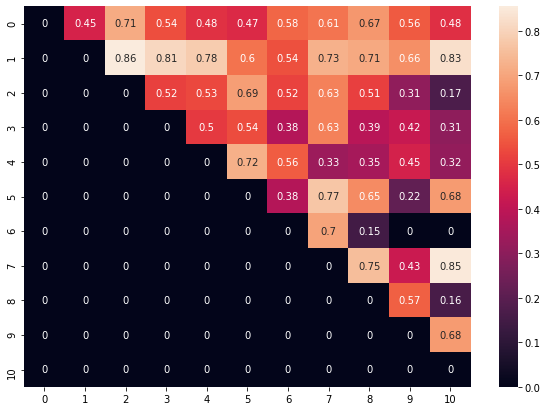

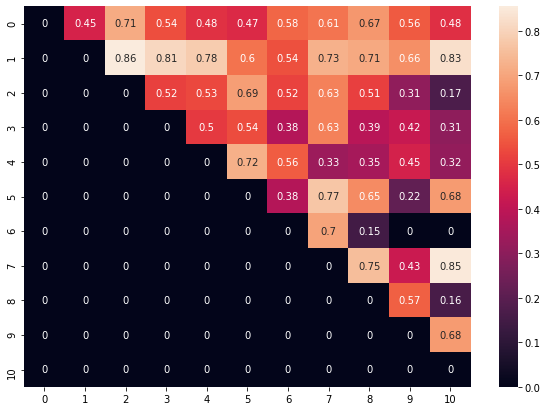

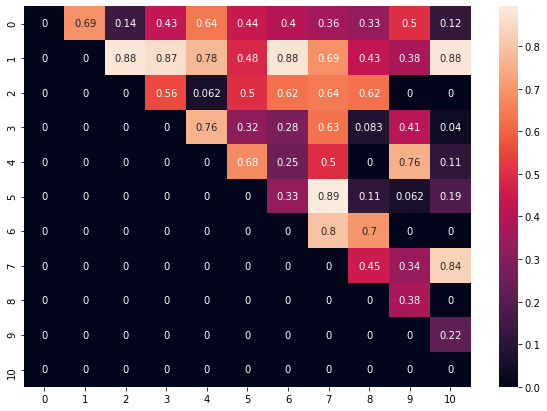

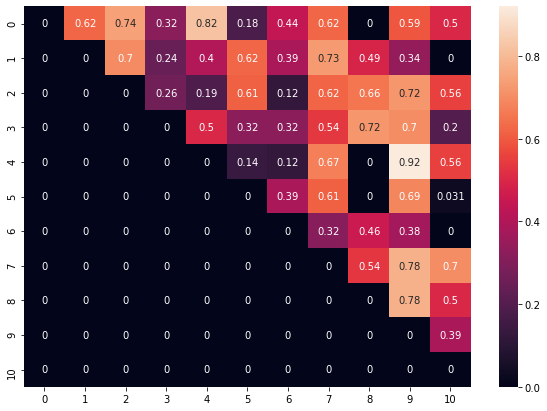

In [15]:
labels = print(list(range(len(syn_list))))

# deepface_all
df_cm = pd.DataFrame(results_df_all, labels, labels)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# deepface
df_cm = pd.DataFrame(results_df, labels, labels)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# pointnet
df_cm = pd.DataFrame(results_pn, labels, labels)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# randomforest
df_cm = pd.DataFrame(results_rf, labels, labels)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# ensemble
df_cm = pd.DataFrame(results_rn, labels, labels)        
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
